###    Time Series Forcasting

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [18]:
data = pd.read_csv('airline.csv')
print(data.head(10))

     Month  Thousands of Passengers
0  1949-01                    112.0
1  1949-02                    118.0
2  1949-03                    132.0
3  1949-04                    129.0
4  1949-05                    121.0
5  1949-06                    135.0
6  1949-07                    148.0
7  1949-08                    148.0
8  1949-09                    136.0
9  1949-10                    119.0


In [40]:
data = pd.read_csv('airline.csv', skiprows=1)
data.columns = ['Month', 'Passengers']
data['Month'] = data['Month'].astype(str)
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m', errors='coerce')
data = data.dropna(subset=['Month'])
data['Passengers'] = data['Passengers'].astype(int)
data = data.set_index('Month')

In [46]:
data.head()

,Passengers
Month,
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135


In [36]:
data.tail()

,Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


###   Plotting the time series data

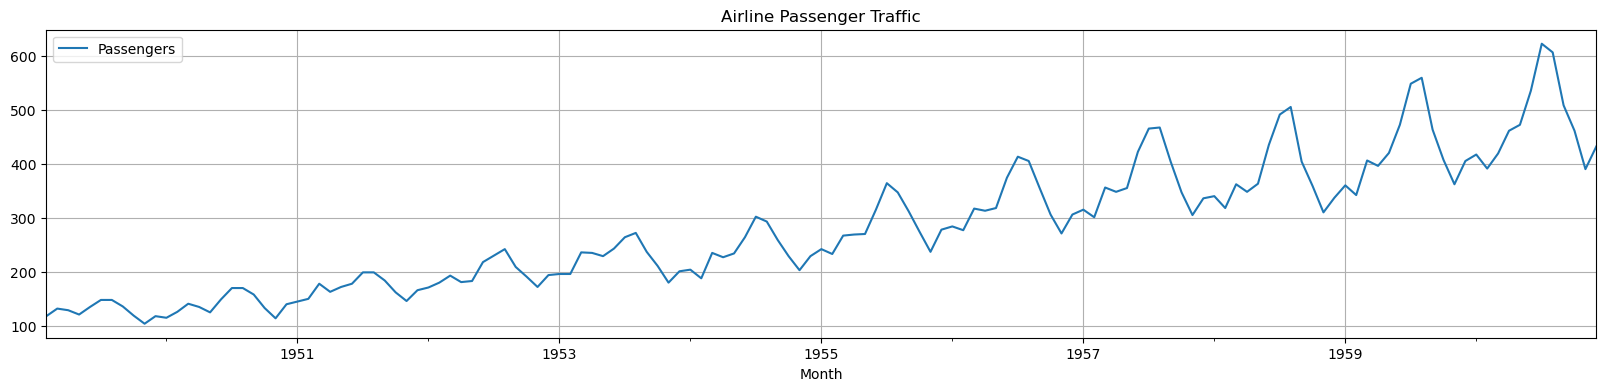

In [50]:
data.plot(figsize=(20, 4))
plt.grid()
plt.legend(loc="best")
plt.title('Airline Passenger Traffic')
plt.show(block=False)





### Treating Missing Value

##### Mean Imputation

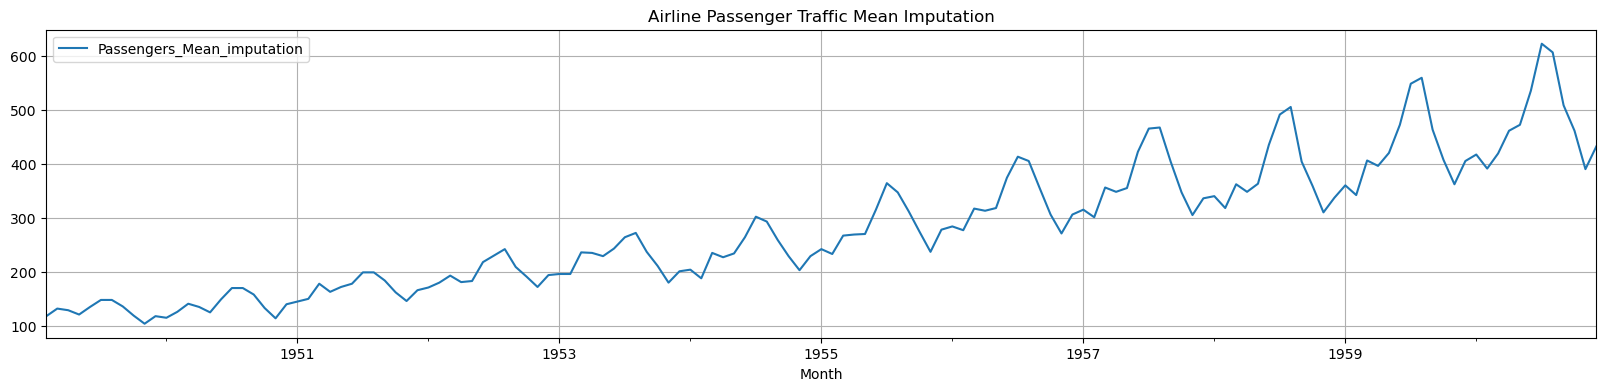

In [55]:
data= data.assign(Passengers_Mean_imputation = data.Passengers.fillna(data.Passengers.mean()))
data[['Passengers_Mean_imputation']].plot(figsize=(20, 4))
plt.grid()
plt.legend(loc="best")
plt.title('Airline Passenger Traffic Mean Imputation')
plt.show(block=False)

##### Linear Interpolation

In [64]:
# Checking if the 'Passengers_Linear_interpolation' column exists
if 'Passengers_Linear_interpolation' in data.columns:
    # Assigning the 'Passengers_Linear_interpolation' column to 'Passengers'
    data['Passengers'] = data['Passengers_Linear_interpolation']
    
    # Dropping the columns 'Passengers_Mean_imputation' and 'Passengers_Linear_interpolation'
    data.drop(columns=['Passengers_Mean_imputation', 'Passengers_Linear_interpolation'], inplace=True)
else:
    print("Column 'Passengers_Linear_interpolation' does not exist in the dataframe.")

# Displaying the first few rows of the dataframe.
data.head()


Column 'Passengers_Linear_interpolation' does not exist in the dataframe.


,Passengers,Passengers_Mean_imputation
Month,,
1949-02-01,118,118
1949-03-01,132,132
1949-04-01,129,129
1949-05-01,121,121
1949-06-01,135,135








#### Detecting Outlier

##### Box plot and interquartile range

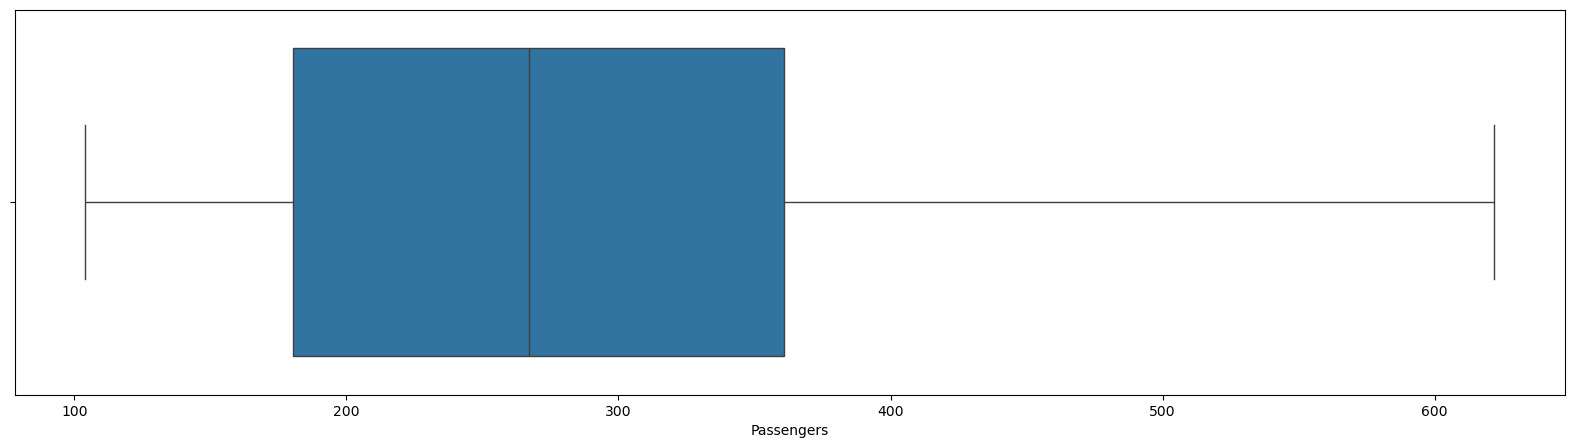

In [78]:
import seaborn as sns
fig = plt.subplots(figsize=(20, 5))
ax = sns.boxplot(x=data['Passengers'], whis=1.5)
plt.show()

##### Histogram plot

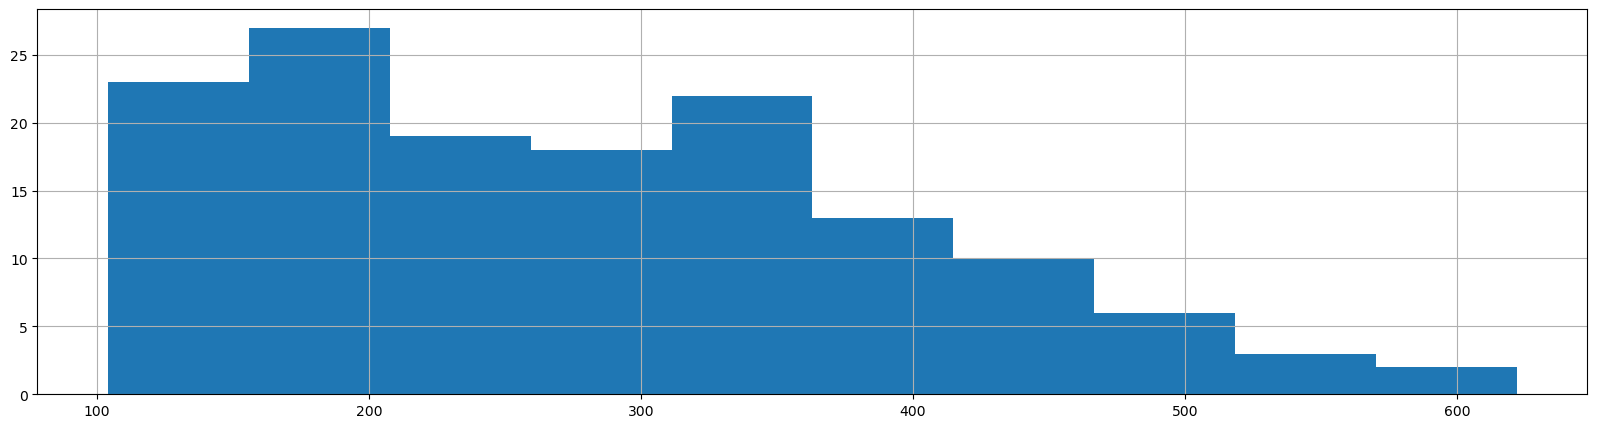

In [84]:
fig, ax = plt.subplots(figsize=(20, 5))
data['Passengers'].hist(ax=ax)
plt.show()

#### Time Series Decomposition

#####  Additive Seasonal Decomposition

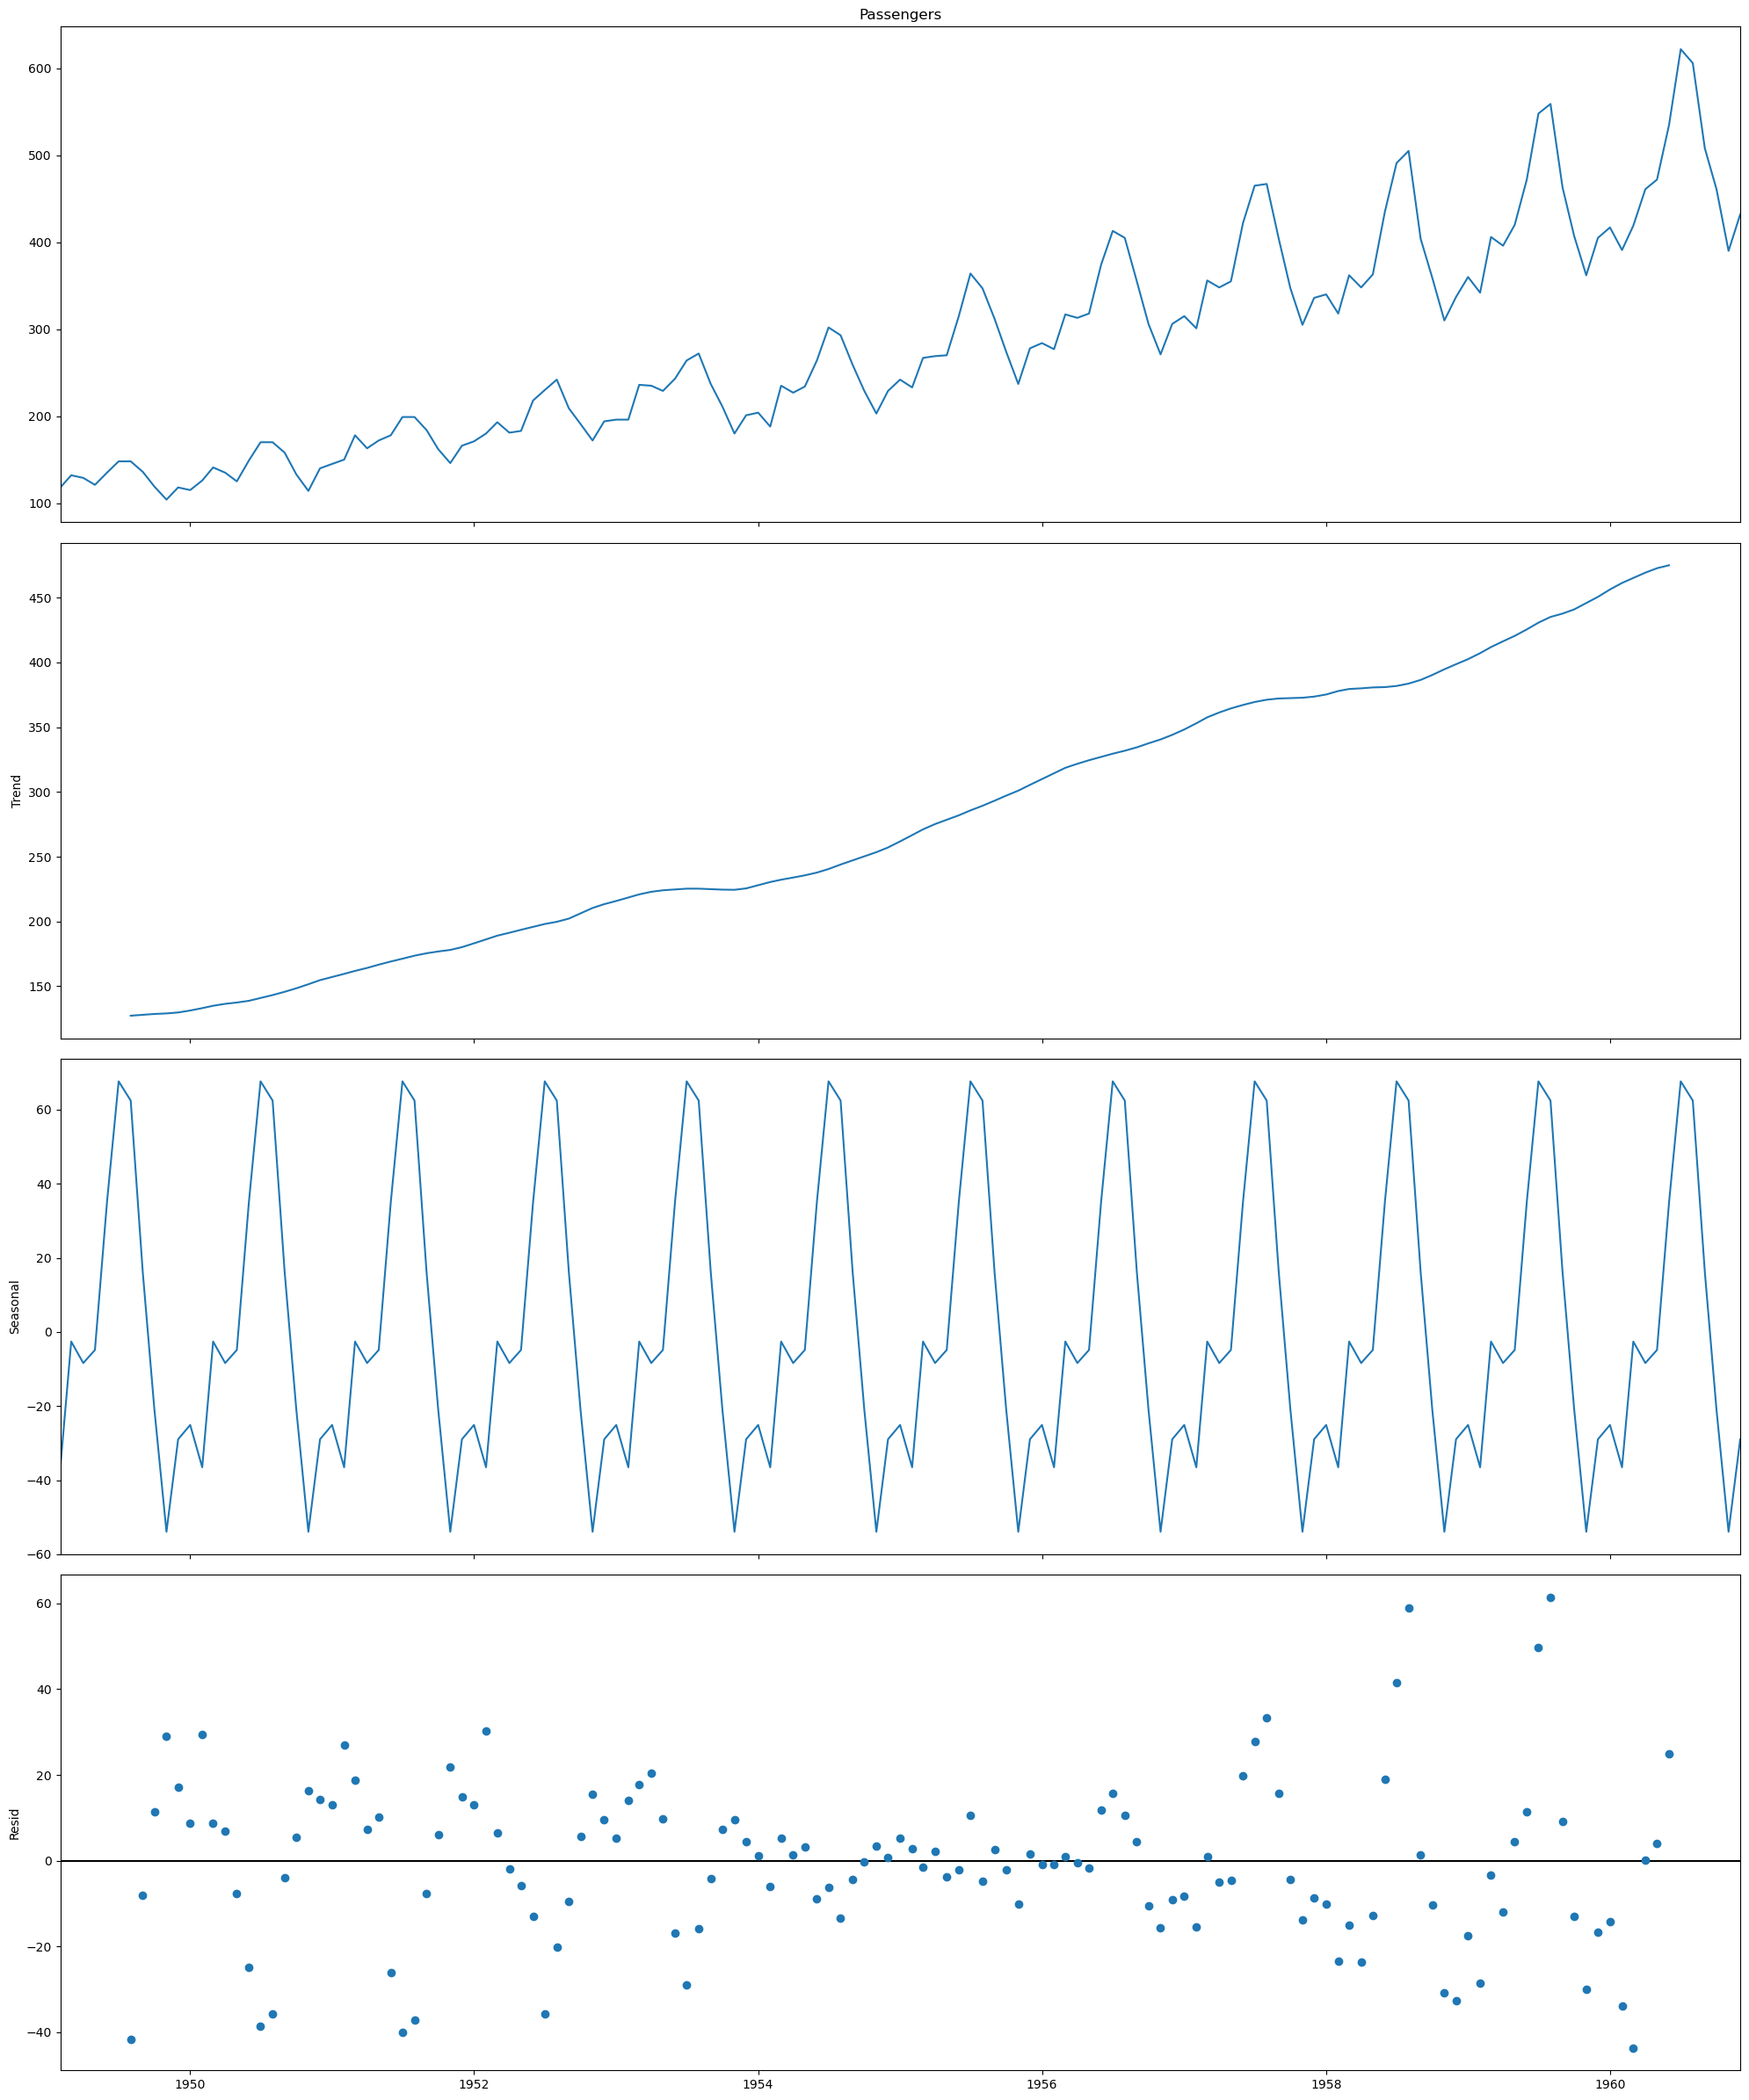

In [96]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 20, 24
decomposition = sm.tsa.seasonal_decompose(data['Passengers'], model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()







##### Multiplicative Seasonal Decomposition

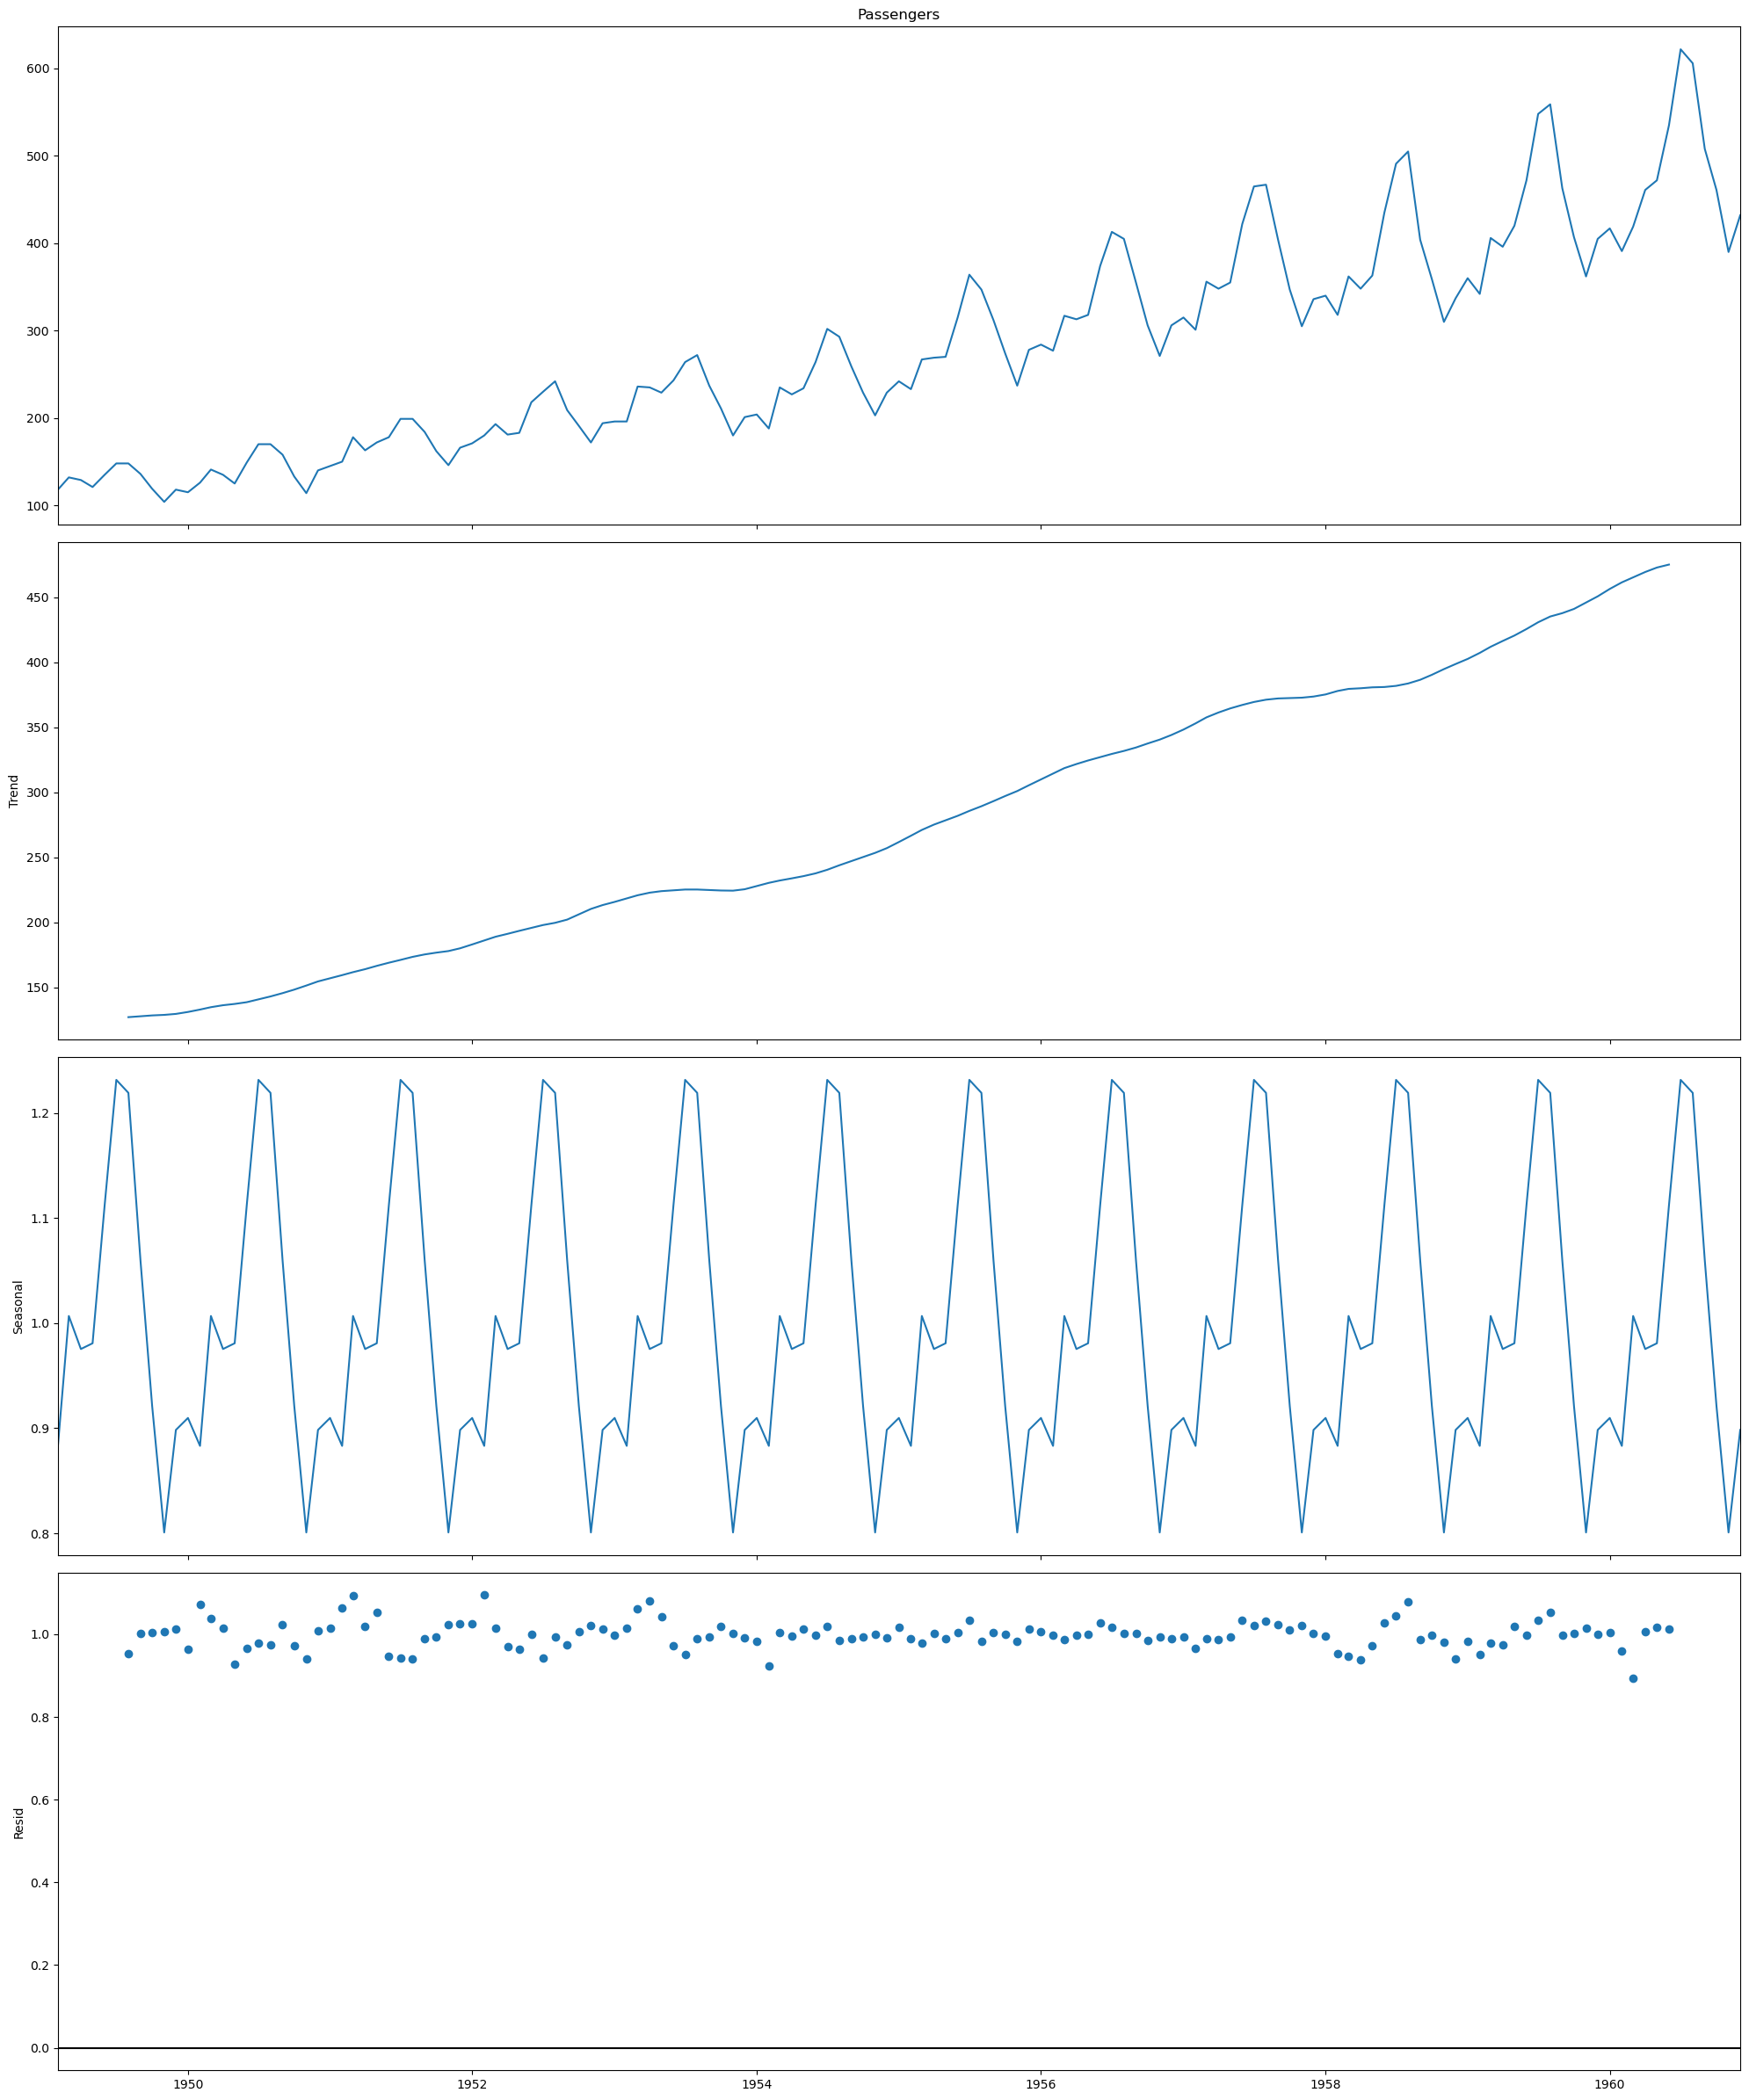

In [100]:
decomposition = sm.tsa.seasonal_decompose(data['Passengers'], model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()




### Building and Evaluating Time Series Forcast

#### Splitting the time series data into training and test set

In [123]:
train_len = 120
train = data[0:train_len] # First 120 months as training set
test = data[train_len:] # Last 24 months as out_of_time test set









### Simple Time Series Methods

### 1. Naive Method

In [153]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Passengers'].iloc[-1]

#### Plotting train, test and forecast

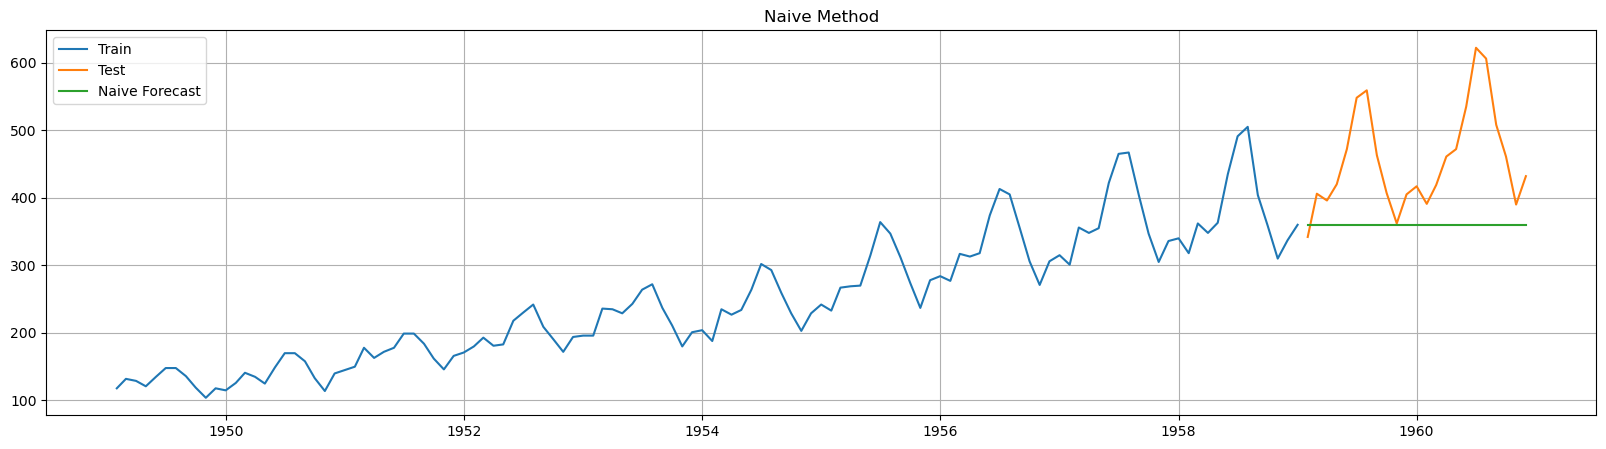

In [155]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive Forecast')
plt.legend(loc="best")
plt.title('Naive Method')
plt.show()  


### Calculating the Performance of the Naive Method

#### Calculating Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE)

In [159]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs((test['Passengers'] - y_hat_naive['naive_forecast']) / test['Passengers'])) * 100, 2)

results = pd.DataFrame({
    'Methods': ['Naive Method'],
    'RMSE': [rmse],
    'MAPE': [mape]
})
results = results[['Methods', 'RMSE', 'MAPE']]
results

,Methods,RMSE,MAPE
0,Naive Method,121.24,19.62


### 2. Simple Average Method

In [162]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Passengers'].mean()

#### Plot train, test and forecast

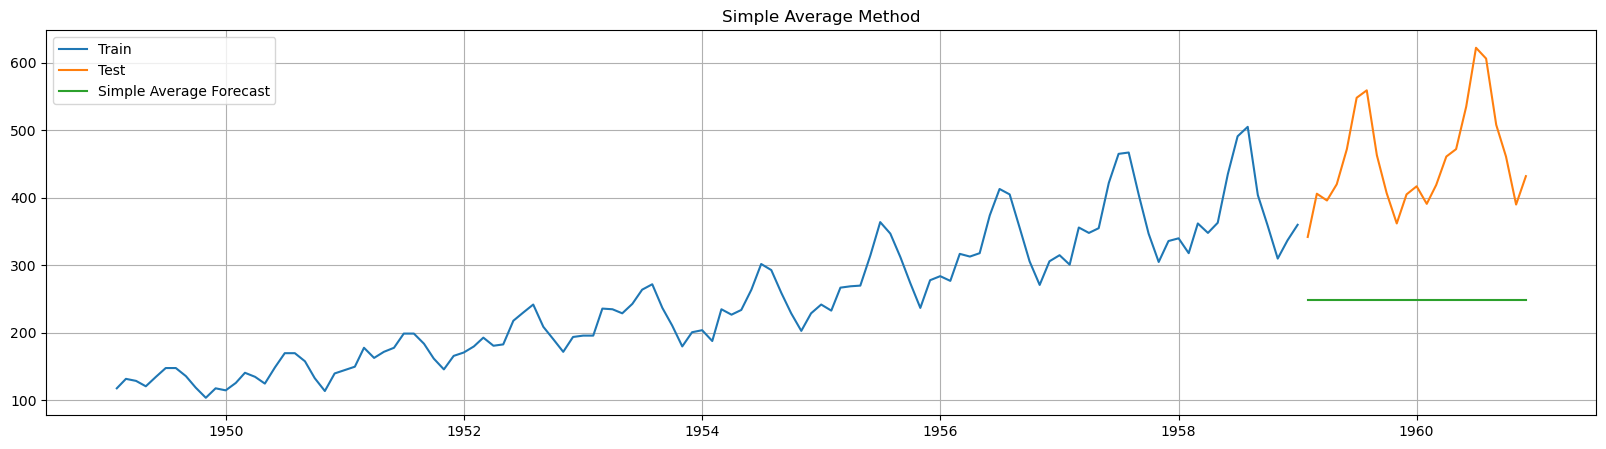

In [165]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple Average Forecast')
plt.legend(loc="best")
plt.title('Simple Average Method')
plt.show()  

#### Calculating RMSE AND MAPE

In [168]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs((test['Passengers'] - y_hat_avg['avg_forecast']) / test['Passengers'])) * 100, 2)

tempResults = pd.DataFrame({
    'Methods': ['Simple Average Method'],
    'RMSE': [rmse],
    'MAPE': [mape]
})
results = pd.concat([results, tempResults])
results = results[['Methods', 'RMSE', 'MAPE']]
results

,Methods,RMSE,MAPE
0,Naive Method,121.24,19.62
0,Simple Average Method,220.94,44.32


### 3. Simple Moving Average Method

In [206]:
y_hat_sma = data.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = y_hat_sma['Passengers'].rolling(window=ma_window).mean()
y_hat_sma['sma_forecast'].iloc[train_len:] = y_hat_sma['sma_forecast'].iloc[train_len-1]

#### Plot Train, Test and Forecast

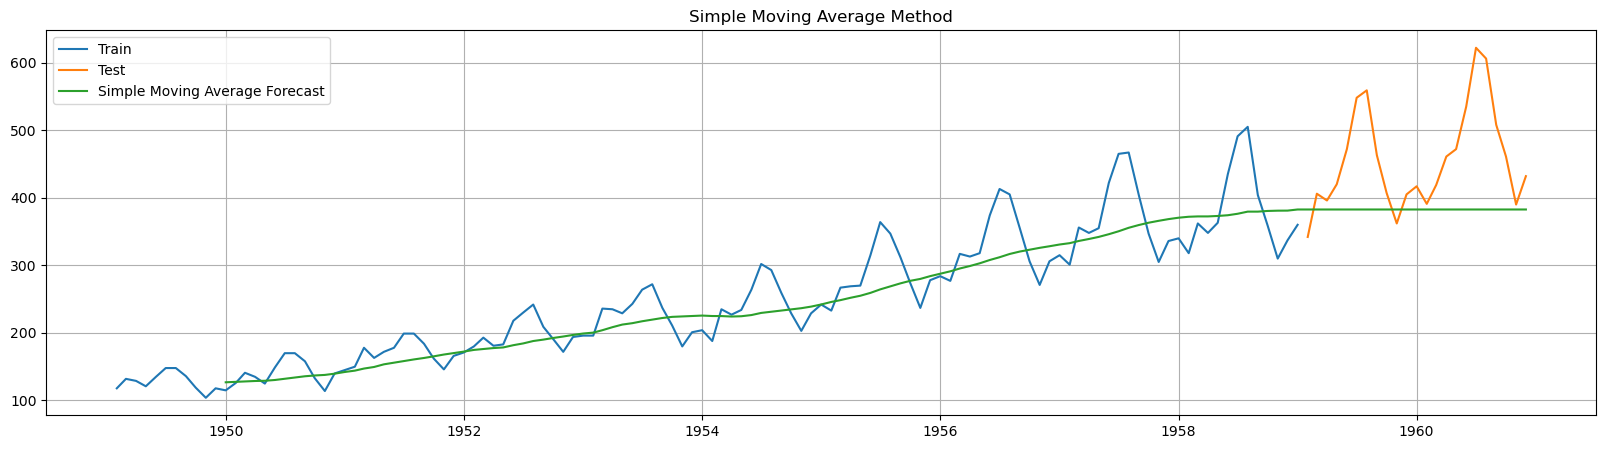

In [208]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple Moving Average Forecast')
plt.legend(loc="best")
plt.title('Simple Moving Average Method')
plt.show()  

#### Calculating RMSE AND MAPE

In [212]:
from sklearn.metrics import mean_squared_error
y_hat_sma_forecast = y_hat_sma['sma_forecast'].iloc[train_len:]
test = data.iloc[train_len:]
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma_forecast)).round(2)
mape = np.round(np.mean(np.abs((test['Passengers'] - y_hat_sma_forecast) / test['Passengers'])) * 100, 2)
tempResults = pd.DataFrame({
    'Methods': ['Simple Moving Average Forecast'],
    'RMSE': [rmse],
    'MAPE': [mape]
})
results = pd.concat([results, tempResults])
results = results[['Methods', 'RMSE', 'MAPE']]
results

,Methods,RMSE,MAPE
0,Naive Method,121.24,19.62
0,Simple Average Method,220.94,44.32
0,Simple Moving Average Forecast,104.16,15.60


### Exponential Smoothing Method
#### 4. Simple Exponential Smoothing

In [227]:
data.index = pd.to_datetime(data.index)
data.index.freq = 'MS'
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Passengers'])
model_fit = model.fit(smoothing_level=0.2, optimized=False)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24)
y_hat_ses.head()

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Passengers,Passengers_Mean_imputation,ses_forecast
Month,,,
1959-02-01,342,342,371.917858
1959-03-01,406,406,371.917858
1959-04-01,396,396,371.917858
1959-05-01,420,420,371.917858
1959-06-01,472,472,371.917858


#### Plot, Train and Forecast

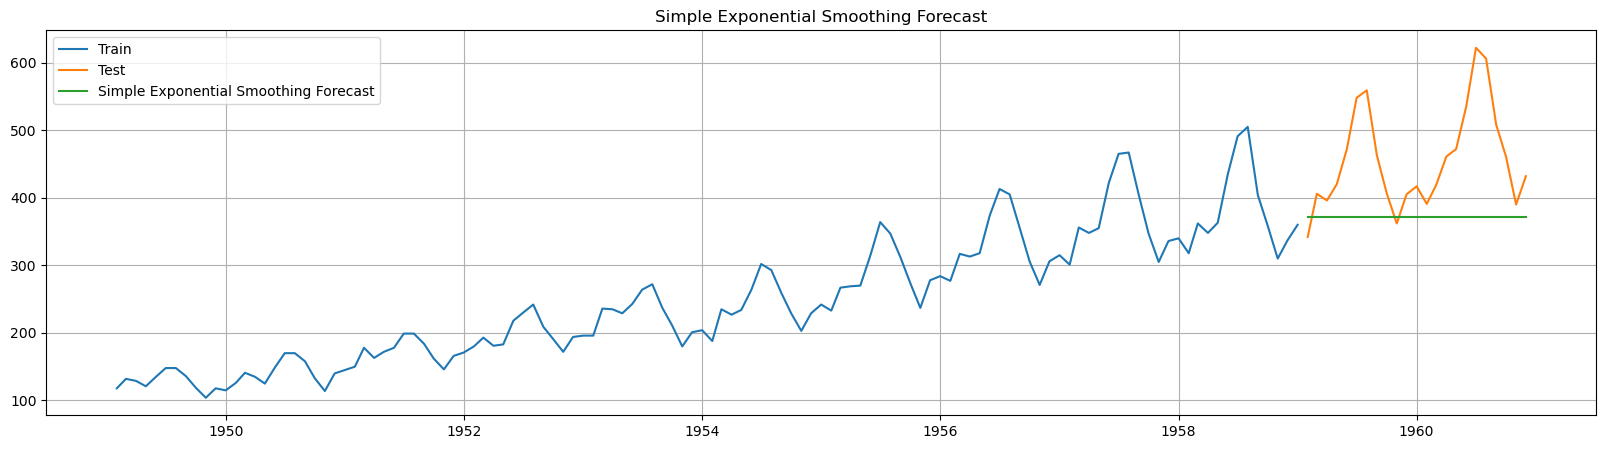

In [233]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple Exponential Smoothing Forecast')
plt.legend(loc="best")
plt.title('Simple Exponential Smoothing Forecast')
plt.show()  

#### Calculating RSME and MAPE

In [237]:
rmse = np.sqrt(mean_squared_error(test['Passengers'],y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs((test['Passengers'] - y_hat_ses['ses_forecast'])/ test['Passengers'])) * 100, 2)
tempResults = pd.DataFrame({
    'Methods': ['Simple Exponential Smoothing Forecast'],
    'RMSE': [rmse],
    'MAPE': [mape]
})
results = pd.concat([results, tempResults])
results = results[['Methods', 'RMSE', 'MAPE']]
results

,Methods,RMSE,MAPE
0,Naive Method,121.24,19.62
0,Simple Average Method,220.94,44.32
0,Simple Moving Average Forecast,104.16,15.60
0,Simple Exponential Smoothing Forecast,112.01,17.48








### 5. Holt's Method With Trend

In [243]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Passengers']),seasonal_periods=12, trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 131.93333333333322, 'initial_trend': -0.5333333333333254, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


#### Plot Train, Test And Forecast

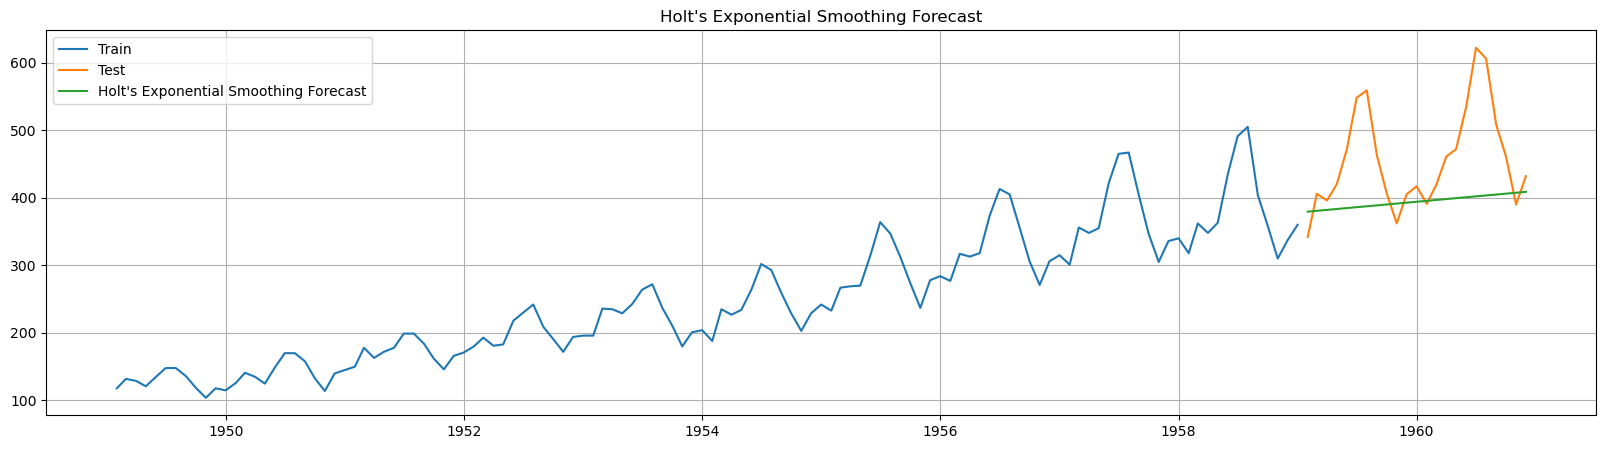

In [260]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_holt['holt_forecast'],label='Holt\'s Exponential Smoothing Forecast')
plt.legend(loc="best")
plt.title('Holt\'s Exponential Smoothing Forecast')
plt.show()  

#### Calculating RSME And MAPE

In [263]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs((test['Passengers'] - y_hat_holt['holt_forecast'])/ test['Passengers'])) * 100, 2)
tempResults = pd.DataFrame({
    'Methods': ['Holt\'s Exponential Smoothing Forecast'],
    'RMSE': [rmse],
    'MAPE': [mape]
})
results = pd.concat([results, tempResults])
results = results[['Methods', 'RMSE', 'MAPE']]
results

,Methods,RMSE,MAPE
0,Naive Method,121.24,19.62
0,Simple Average Method,220.94,44.32
0,Simple Moving Average Forecast,104.16,15.60
0,Simple Exponential Smoothing Forecast,112.01,17.48
0,Holt's Exponential Smoothing Forecast,94.59,13.75







### 6. Holt's Winter's Additive Method With Trend And Seasonality

In [268]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']),seasonal_periods=12, trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hwa_forecast'] = model_fit.forecast(23)

{'smoothing_level': 0.23664628690277897, 'smoothing_trend': 2.4639036251860125e-10, 'smoothing_seasonal': 0.7633537119162593, 'damping_trend': nan, 'initial_level': 119.06349141540223, 'initial_trend': 2.312032346049103, 'initial_seasons': array([ -3.38865685,   9.2043327 ,   4.17358947,  -4.45329457,
         9.7479721 ,  21.97831612,  19.65034468,   5.5158419 ,
       -13.3715079 , -28.08000703, -11.93849861, -15.05081336]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


#### Plot Train, Test And Forecast

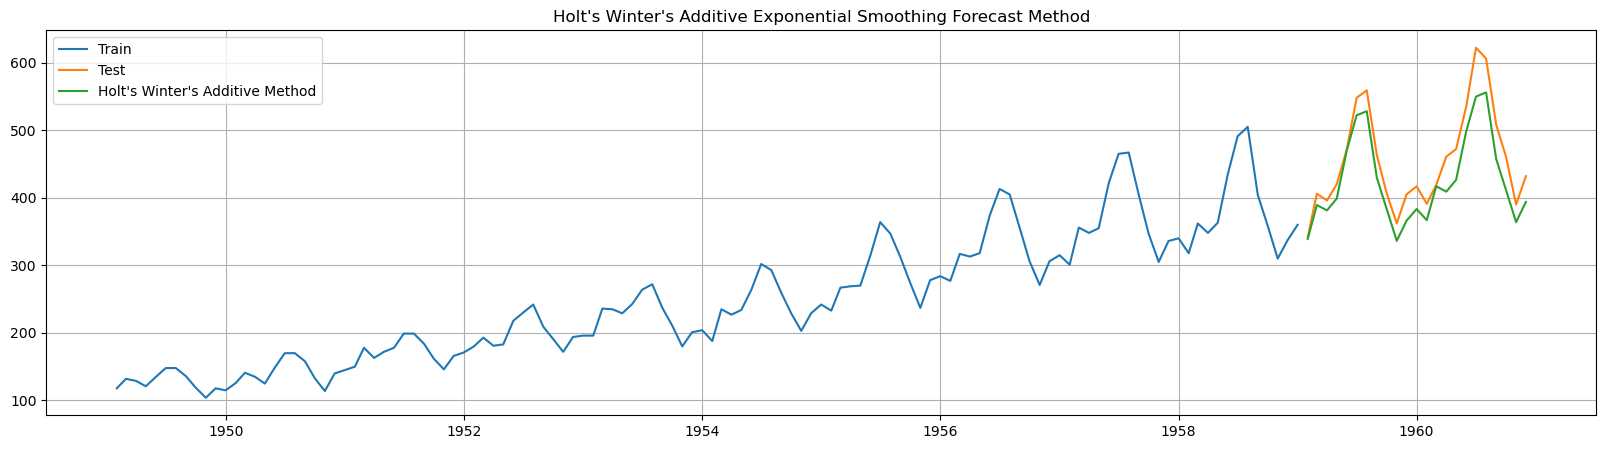

In [275]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwa['hwa_forecast'],label='Holt\'s Winter\'s Additive Method')
plt.legend(loc="best")
plt.title('Holt\'s Winter\'s Additive Exponential Smoothing Forecast Method')
plt.show()  

#### Calculating RSME And MAPE

In [280]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwa['hwa_forecast'])).round(2)
mape = np.round(np.mean(np.abs((test['Passengers'] - y_hat_hwa['hwa_forecast'])/ test['Passengers'])) * 100, 2)
tempResults = pd.DataFrame({
    'Methods': ['Holt\'s Winter\'s Additive Method'],
    'RMSE': [rmse],
    'MAPE': [mape]
})
results = pd.concat([results, tempResults])
results = results[['Methods', 'RMSE', 'MAPE']]
results

,Methods,RMSE,MAPE
0,Naive Method,121.24,19.62
0,Simple Average Method,220.94,44.32
0,Simple Moving Average Forecast,104.16,15.60
0,Simple Exponential Smoothing Forecast,112.01,17.48
0,Holt's Exponential Smoothing Forecast,94.59,13.75
0,Holt's Winter's Additive Method,35.60,6.64


### 7. Holt's Winter's Multiplicative Method With Trend And Seasonality



In [283]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']),seasonal_periods=12, trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hwm_forecast'] = model_fit.forecast(23)

{'smoothing_level': 0.37452555210761707, 'smoothing_trend': 3.0577682760149587e-10, 'smoothing_seasonal': 0.6254744478197194, 'damping_trend': nan, 'initial_level': 121.0336171247121, 'initial_trend': 2.6712360653608336, 'initial_seasons': array([0.95388001, 1.05119075, 0.99974301, 0.9241966 , 1.01270795,
       1.10372749, 1.08979856, 0.99346317, 0.86527977, 0.76883907,
       0.88753233, 0.88519045]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}







#### Plot Train, Test And Forecast

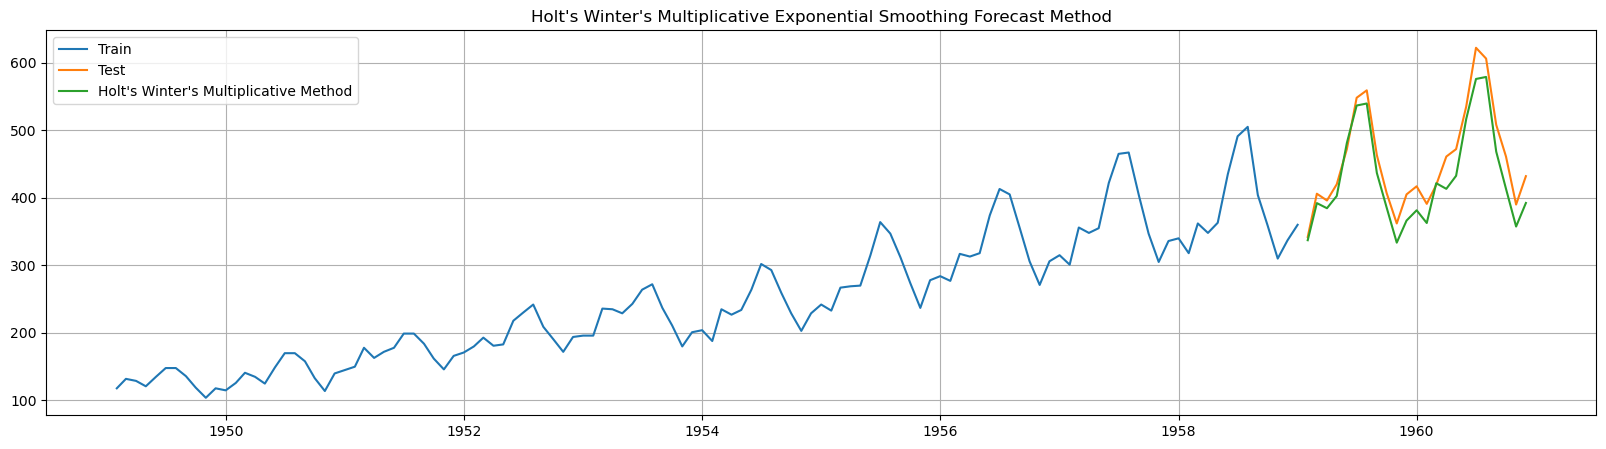

In [287]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwm['hwm_forecast'],label='Holt\'s Winter\'s Multiplicative Method')
plt.legend(loc="best")
plt.title('Holt\'s Winter\'s Multiplicative Exponential Smoothing Forecast Method')
plt.show()  



#### Calculating RSME And MAPE

In [290]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwm['hwm_forecast'])).round(2)
mape = np.round(np.mean(np.abs((test['Passengers'] - y_hat_hwm['hwm_forecast'])/ test['Passengers'])) * 100, 2)
tempResults = pd.DataFrame({
    'Methods': ['Holt\'s Winter\'s Multiplicative Method'],
    'RMSE': [rmse],
    'MAPE': [mape]
})
results = pd.concat([results, tempResults])
results = results[['Methods', 'RMSE', 'MAPE']]
results

,Methods,RMSE,MAPE
0,Naive Method,121.24,19.62
0,Simple Average Method,220.94,44.32
0,Simple Moving Average Forecast,104.16,15.60
0,Simple Exponential Smoothing Forecast,112.01,17.48
0,Holt's Exponential Smoothing Forecast,94.59,13.75
0,Holt's Winter's Additive Method,35.60,6.64
0,Holt's Winter's Multiplicative Method,29.72,5.82



#####  Hence it is recommended to use Holt's Winter's Multiplicative Method for accurate prediction for time series as it has the least RSME and MAPE for this data set